In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import norm, rv_histogram

import utils

In [18]:
# Unfolded results from https://arxiv.org/abs/2110.14023
df = pd.read_csv(
    "uBooNE/microboone_cc_inclusive_cross_section.txt",
    sep="\t",
    skiprows=7,
    nrows=10,
    names=["i", "bin_min", "bin_max", "bin_mean", "xsec", "xsec_uncert"],
    index_col="i",
)
print(df)
bins = np.append(df["bin_min"].to_numpy(), df["bin_max"].iloc[-1])
print(bins)
pre_regularised = df["xsec"].to_numpy()
pre_regularised_h = (pre_regularised, bins)

    bin_min  bin_max  bin_mean    xsec  xsec_uncert
i                                                  
1     0.200    0.540    0.3818  0.3367      0.04369
2     0.540    0.705    0.6220  0.6751      0.06562
3     0.705    0.805    0.7546  0.9309      0.08193
4     0.805    0.920    0.8615  1.0920      0.08613
5     0.920    1.050    0.9833  1.1920      0.09354
6     1.050    1.200    1.1220  1.2340      0.11990
7     1.200    1.375    1.2820  1.2920      0.13940
8     1.375    1.570    1.4630  1.4010      0.18770
9     1.570    2.050    1.7350  1.5710      0.26410
10    2.050    4.000    2.6190  1.9770      0.37800
[0.2   0.54  0.705 0.805 0.92  1.05  1.2   1.375 1.57  2.05  4.   ]


In [26]:
# Regularisation matrix
pre_A = np.loadtxt(
    "uBooNE/microboone_cc_inclusive_addtl_smr_mat.txt",
    skiprows=6,
    max_rows=10,
)
print(pre_A)
pre_A_inv = np.linalg.inv(pre_A)
unfolded = pre_A_inv @ pre_regularised
unfolded_h = (unfolded, bins)

[[ 7.7193e-01  1.6067e-01  2.5056e-03 -2.3549e-02 -1.3922e-02  5.3099e-03
   1.3827e-02  1.3296e-02  1.8587e-03 -1.3563e-02]
 [ 5.1029e-01  4.6149e-01  1.4382e-01  4.8657e-02  3.5189e-03 -1.2790e-02
  -1.7596e-02 -1.1689e-02  2.0003e-03  1.7811e-02]
 [-1.2146e-03  4.8313e-01  3.0137e-01  2.0307e-01  6.7876e-02 -1.5387e-02
  -3.1367e-02 -1.2405e-02  2.0622e-02  1.2695e-02]
 [-1.7011e-01  2.7494e-01  2.9489e-01  2.8457e-01  1.7260e-01  7.1278e-02
   2.3583e-02  8.9150e-03  8.9130e-03 -1.0599e-02]
 [-1.7679e-02  2.0195e-02  1.3275e-01  2.4059e-01  2.7945e-01  2.3071e-01
   1.3165e-01  3.7466e-02 -3.1675e-02 -1.6003e-02]
 [ 2.3539e-01 -2.0050e-01 -4.3079e-02  1.4648e-01  3.1638e-01  3.4103e-01
   2.2967e-01  8.3719e-02 -2.9863e-02 -4.6007e-03]
 [ 3.1528e-01 -3.0813e-01 -9.6519e-02  9.7406e-02  2.6085e-01  3.1883e-01
   2.6662e-01  1.4968e-01  6.0373e-02  2.0519e-02]
 [ 3.5910e-02 -1.9540e-01 -1.6254e-02  8.9789e-02  1.4139e-01  1.9417e-01
   2.3585e-01  2.0440e-01  2.0473e-01  8.0439e-02]


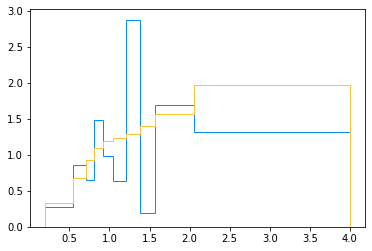

In [27]:
plt.stairs(*unfolded_h)
plt.stairs(*pre_regularised_h)
#plt.stairs(nominal, bins, linestyle="dashed")

In [32]:
# Covariance
cov_pre_regularised = np.loadtxt(
    "uBooNE/microboone_cc_inclusive_cov_mat.txt",
    skiprows=6,
    max_rows=10,
)
cov_pre_regularised_inv = np.linalg.inv(cov_pre_regularised)
cor_pre_regularised = cov_pre_regularised / (
    np.sqrt(np.diag(cov_pre_regularised))[:, None]
    * np.sqrt(np.diag(cov_pre_regularised))[None, :]
)

cov_unfolded = pre_A_inv @ cov_pre_regularised @ pre_A_inv.T
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None]
    * np.sqrt(np.diag(cov_unfolded))[None, :]
)

In [33]:
(
    np.sqrt(np.max(np.diag(cov_unfolded))),
    np.max(cor_unfolded),
    np.min(cor_unfolded),
    np.min(cov_unfolded),
    np.sqrt(np.max(np.diag(cov_pre_regularised))),
    np.max(cor_pre_regularised),
    np.min(cor_pre_regularised),
    np.min(cov_pre_regularised),
)

(2.0111501326479795,
 1.0000000000000002,
 -0.8431098799129668,
 -2.535376571185199,
 0.3779947089576784,
 1.0000000000000002,
 -0.17362295284575865,
 -0.0028676)

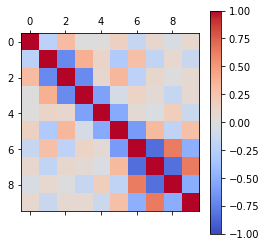

In [35]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

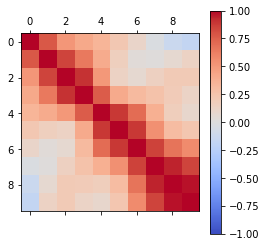

In [34]:
plt.matshow(cor_pre_regularised, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

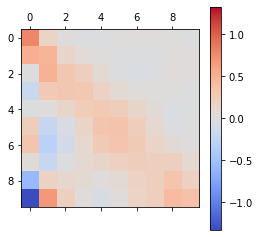

In [39]:
mv = np.max(np.abs(pre_A))
plt.matshow(pre_A, cmap="coolwarm", vmin=-mv, vmax=mv)
plt.colorbar()

Text(0, 0.5, '$\\sigma(E_\\nu)$ / [$10^{-38}$cm$^2$ / nucleon]')

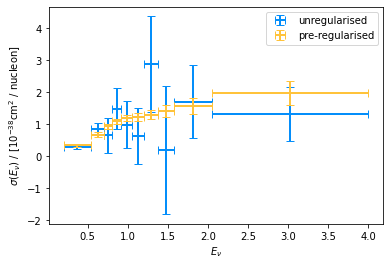

In [47]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="unregularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = pre_regularised_h[0]
yerr = np.sqrt(np.diag(cov_pre_regularised))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="pre-regularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)
plt.legend()
plt.xlabel(r"$E_\nu$")
plt.ylabel(r"$\sigma(E_\nu)$ / [$10^{-38}$cm$^2$ / nucleon]")

0.06844036259260178 2.1840571845738292


array([-0.12001037,  0.08830536,  0.05974093,  0.04315437,  0.01010331,
        0.00569193,  0.01894247,  0.00616511, -0.01344085, -0.03021191])

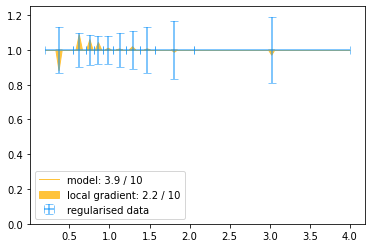

In [45]:
utils.model_ratio_plot(
    pre_regularised,
    pre_regularised,
    cov_pre_regularised,
    pre_A,
    bins=bins,
    data_label="regularised data",
)
#plt.xlabel(r"$\delta p_T$ / [GeV/c]")
#plt.ylabel(
#    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{nominal}}{\mathrm{d}\delta p_T}$"
#)